# Imports and setup

In [1]:
from transformers import ElectraForPreTraining, ElectraTokenizerFast, pipeline, AutoTokenizer, AutoModel
from datasets import load_dataset, ClassLabel
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import pandas as pd
import nlp
import matplotlib.pyplot as plt

- Small-E-Czech is a transformer trained on Czech corpora by Seznam

In [2]:
model_name = "Seznam/small-e-czech"
# pipe = pipeline(task="text-classification", model=model_name)

# Data loading, manipulation and exploration

In [3]:
# load data into pandas

# df = pd.read_csv('data/sample_data.csv')
# df_train, df_test = train_test_split(df, test_size=0.33, random_state=42, shuffle=True)

# df_train.to_csv('data/sample_data_train.csv', index=False)
# df_test.to_csv('data/sample_data_test.csv', index=False)

df_train = pd.read_csv('data/sample_data_train.csv', dtype={'text': str})
df_test = pd.read_csv('data/sample_data_test.csv')

df_train.head(10)

,text,label
0,V zoologické zahradě měli lachtana.,1
1,"Když budu celý život tvrdě pracovat, tak si st...",0
2,Zrzavá liška běžela v lese.,1
3,Dneska jsem viděl jak soused kácel strom.,0
4,Matematika je lepší než zeměpis.,0
5,Slepice snáší vejce.,1
6,Včera večer jsme na procházce krmili labutě.,1
7,Nasadil jsem si brýle.,0
8,Večeřeli jsme v kuchyni.,0
9,Kohout ráno všechny vzbudil.,1


In [4]:
# load into hugging_face dataset object and cast label as target

ds = load_dataset('csv', data_files={'train': 'data/sample_data_train.csv', 'test': 'data/sample_data_test.csv'})
label_features = ClassLabel(names=["není zvíře", "je zvíře"])

ds['train'] = ds['train'].cast_column("label", label_features)
ds['test'] = ds['test'].cast_column("label", label_features)

Using custom data configuration default-ff494cef3127c3b8
Found cached dataset csv (C:/Users/capek/.cache/huggingface/datasets/csv/default-ff494cef3127c3b8/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\capek\.cache\huggingface\datasets\csv\default-ff494cef3127c3b8\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-2b2c3e79c40a7e30.arrow
Loading cached processed dataset at C:\Users\capek\.cache\huggingface\datasets\csv\default-ff494cef3127c3b8\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-d01a42f684ac3fa5.arrow


In [5]:
# examine values

print(ds['train'].features)
print(ds['train'][0])
print(ds['test'].features)
print(ds['test'][0])

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['není zvíře', 'je zvíře'], id=None)}
{'text': 'V zoologické zahradě měli lachtana.', 'label': 1}
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['není zvíře', 'je zvíře'], id=None)}
{'text': 'Pohladil jsem kočku.', 'label': 1}


In [6]:
# features = ds.features.copy()
# features["label"] = ClassLabel(names=["není zvíře", "je zvíře"])
# def adjust_labels(batch):
# #     batch["label"] = [sentiment + 1 for sentiment in batch["label"]]
#     return batch
# ds = ds.map(adjust_labels, batched=True, features=features)
# ds
# ds.features

In [7]:
# display dataset as pandas dataframe

ds['train'].set_format(type="pandas")
df = ds['train'][:]
df.head()

,text,label
0,V zoologické zahradě měli lachtana.,1
1,"Když budu celý život tvrdě pracovat, tak si st...",0
2,Zrzavá liška běžela v lese.,1
3,Dneska jsem viděl jak soused kácel strom.,0
4,Matematika je lepší než zeměpis.,0


In [8]:
# map labels to label name

def label_int2str(row):
    return ds["train"].features["label"].int2str(row)

df['label_name'] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,V zoologické zahradě měli lachtana.,1,je zvíře
1,"Když budu celý život tvrdě pracovat, tak si st...",0,není zvíře
2,Zrzavá liška běžela v lese.,1,je zvíře
3,Dneska jsem viděl jak soused kácel strom.,0,není zvíře
4,Matematika je lepší než zeměpis.,0,není zvíře


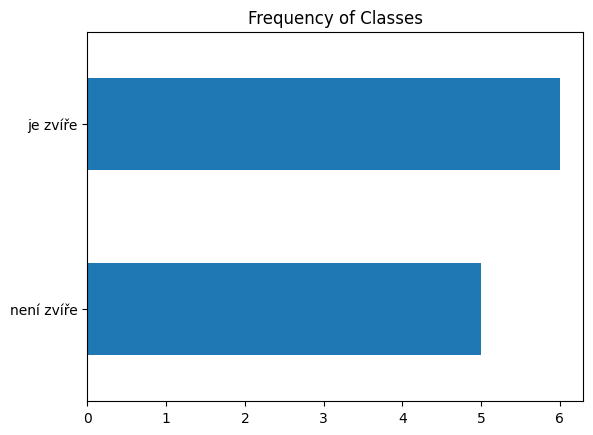

In [9]:
# displaying class frequencies

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

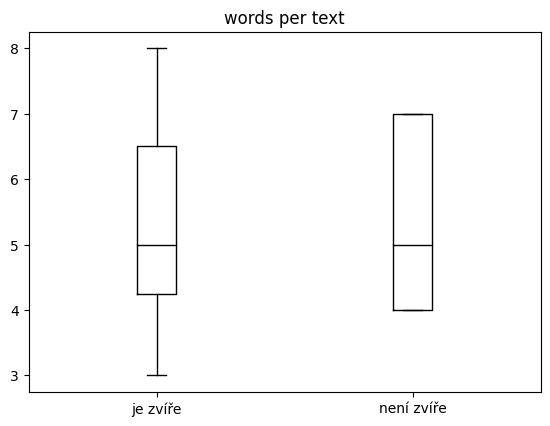

In [10]:
# displaying boxplots for word frequencies per class

df["words per text"] = df["text"].str.split().apply(len)
df.boxplot("words per text", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [11]:
ds.reset_format()

# Tokenization

In [12]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenized_data_train = tokenizer(ds['train']['text'], return_tensors="tf", padding=True, truncation=True)
labels_train = np.array(ds['train']['label'])
tokenized_data_test = tokenizer(ds['test']['text'], return_tensors="tf", padding=True, truncation=True)
labels_test = np.array(ds['test']['label'])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [13]:
# attention mask umožňuje ignorovat padding
tokenized_data_train

{'input_ids': <tf.Tensor: shape=(11, 18), dtype=int32, numpy=
array([[    2,    63,  7501,  5368,  6695,  1931, 16102,   154, 10097,
          145,    18,     3,     0,     0,     0,     0,     0,     0],
       [    2,   593,  2631,  1912,  1764, 18973,  4844,    16,   316,
          354,  1633,  6691, 22633, 13960,  1352,  1971,    18,     3],
       [    2,  3596, 11583,   155, 20550, 11871,   246,    63,  9110,
           18,     3,     0,     0,     0,     0,     0,     0,     0],
       [    2,  5462,   409,  6006,   334,  4777,  2049,  6976,  6305,
           18,     3,     0,     0,     0,     0,     0,     0,     0],
       [    2, 16537,   252,  2082,   688, 21387,    18,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [    2, 22251, 14416,   300,  8036,    18,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [    2,  5353,  2525,   594,   242, 15029,   248,  7024,   249,
        1

In [14]:
# navrácení tokenů k id
tokens = tokenizer.convert_ids_to_tokens(tokenized_data_train[0].ids)
tokens

['[CLS]',
 'v',
 'zoo',
 '##logické',
 'zahradě',
 'měli',
 'lac',
 '##h',
 '##tan',
 '##a',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [15]:
# tisk jako string
tokenizer.convert_tokens_to_string(tokens)

'[CLS] v zoologické zahradě měli lachtana. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [16]:
# počet tokenů ve slovníku
tokenizer.vocab_size

30522

In [17]:
# maximální délka vektoru
# (... mám o tom nějaké pochybnosti ....)

tokenizer.model_max_length

1000000000000000019884624838656

In [18]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [19]:
# tokenizace celého datasetu
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

tokenized = ds.map(tokenize, batched=True, batch_size=None)
tokenized

Loading cached processed dataset at C:\Users\capek\.cache\huggingface\datasets\csv\default-ff494cef3127c3b8\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-a4b1c23a29ffd127.arrow
Loading cached processed dataset at C:\Users\capek\.cache\huggingface\datasets\csv\default-ff494cef3127c3b8\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-43b945026e026c84.arrow


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6
    })
})

# Feature extraction

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_name).to(device)

Some weights of the model checkpoint at Seznam/small-e-czech were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
# tensorflow is also available
from transformers import TFAutoModel

tf_model = TFAutoModel.from_pretrained(model_name)

Some layers from the model checkpoint at Seznam/small-e-czech were not used when initializing TFElectraModel: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFElectraModel were initialized from the model checkpoint at Seznam/small-e-czech.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further training.


In [22]:
text = "Toto je zkušební text"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

print(outputs.last_hidden_state.size())

Input tensor shape: torch.Size([1, 6])
BaseModelOutputWithPastAndCrossAttentions(last_hidden_state=tensor([[[ 3.6099e-01,  5.5451e-05, -1.2910e-04,  ...,  2.7867e-04,
           4.9307e-01, -1.3343e-04],
         [-1.9553e-01, -3.0069e-04, -1.0528e-04,  ...,  9.9561e-05,
          -1.1577e+00, -1.9735e-04],
         [-4.4455e-01, -4.6349e-04, -9.3824e-05,  ...,  3.3250e-04,
           1.7377e-01, -1.3628e-04],
         [-2.3091e-02, -2.4707e-04, -7.6978e-05,  ...,  6.1547e-04,
           6.3975e-01, -1.4361e-04],
         [ 1.0250e+00, -2.7454e-04, -7.3393e-05,  ...,  7.0218e-04,
           4.0733e-01, -2.5776e-04],
         [ 3.6190e-01,  5.5545e-05, -1.2914e-04,  ...,  2.7877e-04,
           4.9256e-01, -1.3352e-04]]]), past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)
torch.Size([1, 6, 256])


<i>"Looking at the hidden state tensor, we see that it has the shape [batch_size, n_tokens, hidden_dim]. In other words, a 256-dimensional vector is returned for each of the 6 input tokens. For classification tasks, it is common practice to just use the hidden state associated with the [CLS] token as the input feature. Since this token appears at the start of each sequence, we can extract it by simply indexing into outputs.last_hidden_state as follows:"</i>

In [23]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 256])

In [24]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [25]:
tokenized.set_format("torch", columns=["input_ids", "token_type_ids", "attention_mask", "label"])
# token_type_ids?

In [26]:
# hidden states
hidden = tokenized.map(extract_hidden_states, batched=True)
hidden

Loading cached processed dataset at C:\Users\capek\.cache\huggingface\datasets\csv\default-ff494cef3127c3b8\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-803f46587f692599.arrow
Loading cached processed dataset at C:\Users\capek\.cache\huggingface\datasets\csv\default-ff494cef3127c3b8\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-11c86f05147e29f7.arrow


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'hidden_state'],
        num_rows: 11
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'hidden_state'],
        num_rows: 6
    })
})

In [27]:
X_train = np.array(hidden["train"]["hidden_state"])
X_test = np.array(hidden["test"]["hidden_state"])
y_train = np.array(hidden["train"]["label"])
y_test = np.array(hidden["test"]["label"])
X_train.shape, X_test.shape

((11, 256), (6, 256))

# Feature visualization

In [28]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

c:\users\capek\pycharm_projects\transformers_for_czech_language\venv\lib\site-packages\umap\umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


,X,Y,label
0,18.511539,0.335300,1
1,17.847797,-0.187524,0
2,18.423594,-0.601737,1
3,17.206350,-0.136309,0
4,17.766651,-1.882842,0


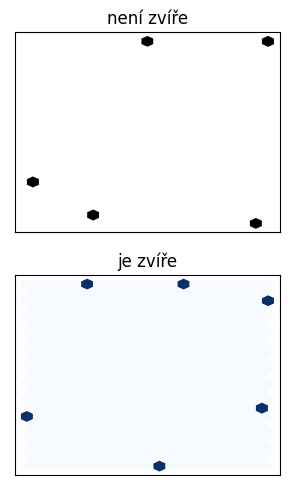

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(3,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues"]
labels = ds["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

# Modelling

In [30]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

0.6666666666666666

In [31]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_test, y_test)

0.5

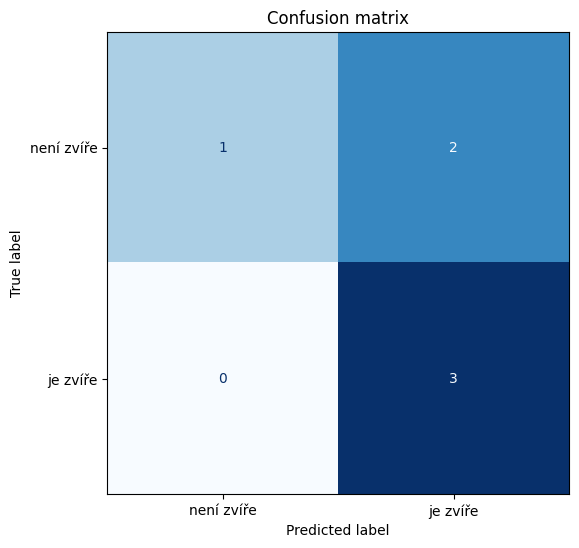

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", ax=ax, colorbar=False)
    plt.title("Confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_test)
plot_confusion_matrix(y_preds, y_test, labels)

In [33]:
from transformers import AutoModelForSequenceClassification

num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at Seznam/small-e-czech were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at Seznam/small-e-czech and are newly initialized: ['classifier.out_proj.bias', 'classifier

In [34]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [35]:
from transformers import Trainer, TrainingArguments

batch_size = 2
logging_steps = len(ds["train"]) // batch_size
my_model_name = f"{model_name}-finetuned-sample"
training_args = TrainingArguments(output_dir=my_model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  log_level="error")

In [36]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized["train"],
                  eval_dataset=tokenized["test"],
                  tokenizer=tokenizer)
trainer.train();

c:\users\capek\pycharm_projects\transformers_for_czech_language\venv\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.685300,0.690307,0.500000,0.333333
2,0.706900,0.690199,0.500000,0.333333


In [37]:
preds_output = trainer.predict(tokenized["test"])
preds_output

PredictionOutput(predictions=array([[ 0.04553166, -0.02032994],
       [ 0.03455681, -0.00521905],
       [ 0.04624285, -0.02193682],
       [ 0.04397796, -0.01517555],
       [ 0.06124493, -0.03241777],
       [ 0.03830513, -0.02477321]], dtype=float32), label_ids=array([1, 1, 1, 0, 0, 0], dtype=int64), metrics={'test_loss': 0.6901993751525879, 'test_accuracy': 0.5, 'test_f1': 0.3333333333333333, 'test_runtime': 0.128, 'test_samples_per_second': 46.873, 'test_steps_per_second': 23.436})

In [38]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_preds

array([0, 0, 0, 0, 0, 0], dtype=int64)

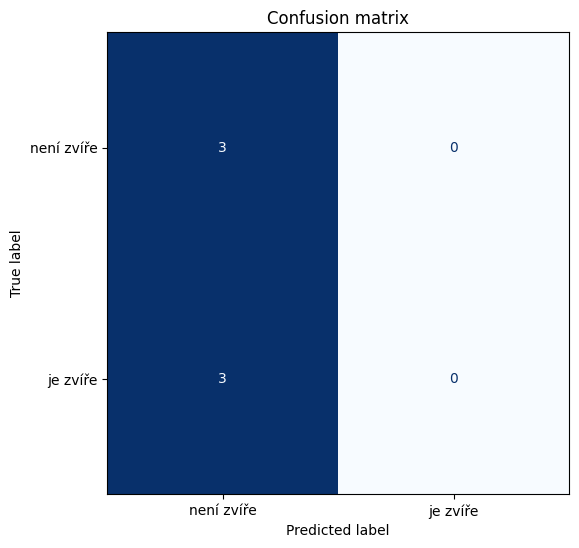

In [39]:
plot_confusion_matrix(y_preds, y_test, labels)

- keras finetuning

In [40]:
from transformers import TFAutoModelForSequenceClassification

tf_model = (TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels))

In [41]:
tokenizer_columns = tokenizer.model_input_names

tf_train_dataset = tokenized["train"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=True,
    batch_size=batch_size)
tf_eval_dataset = tokenized["test"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=False,
    batch_size=batch_size)

In [ ]:
# does not work
import tensorflow as tf

tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy())

tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=2)

# Error analysis

<i>"Before moving on, we should investigate our model's predictions a little bit further. A simple yet powerful technique is to sort the validation samples by the model loss. When we pass the label during the forward pass, the loss is automatically calculated and returned. Here's a function that returns the loss along with the predicted label:"</i>

In [42]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}
     

In [43]:
# Convert our dataset back to PyTorch tensors
tokenized.set_format("torch", 
                            columns=["input_ids", "token_type_ids", "attention_mask", "label"])
# Compute loss values
tokenized["test"] = tokenized["test"].map(
    forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [46]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
2,Jezdili jsme na velbloudovi po poušti.,je zvíře,není zvíře,0.727818
0,Pohladil jsem kočku.,je zvíře,není zvíře,0.726620
1,Pes zaštěkal na kolemjdoucího.,je zvíře,není zvíře,0.713233
3,Atom je základní jednotka hmoty.,není zvíře,není zvíře,0.664008
5,Kalkulačka je kamarád při matematice.,není zvíře,není zvíře,0.662105
4,Nejradši na světě mám můj počítač.,není zvíře,není zvíře,0.647412


In [47]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
4,Nejradši na světě mám můj počítač.,není zvíře,není zvíře,0.647412
5,Kalkulačka je kamarád při matematice.,není zvíře,není zvíře,0.662105
3,Atom je základní jednotka hmoty.,není zvíře,není zvíře,0.664008
1,Pes zaštěkal na kolemjdoucího.,je zvíře,není zvíře,0.713233
0,Pohladil jsem kočku.,je zvíře,není zvíře,0.726620
2,Jezdili jsme na velbloudovi po poušti.,je zvíře,není zvíře,0.727818


# Save model

In [53]:
path = f"models/{my_model_name}"
trainer.save_model(path)

In [57]:
classifier = pipeline("text-classification", model=path)

In [59]:
custom_tweet = "Dnes jsem si v parku hrál se psem."
preds = classifier(custom_tweet, return_all_scores=True)
preds

[[{'label': 'LABEL_0', 'score': 0.5154557228088379},
  {'label': 'LABEL_1', 'score': 0.4845442473888397}]]